# Feature engineering for classification and topic modelling of news headlines using open source

As a first task we want to explore the different labels of category of the gathered news items. Missing values will be filled with 'Missing', rare labels will be grouped as 'Other'.
In a later step we want to train a ML model for text classification to predict a category label (supervised learning) as well as clustering the news into different topics (unsupervised learning) and compare them with the labeled categories.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sql

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

# for saving the pipeline
import joblib

# from feature-engine
from feature_engine.imputation import CategoricalImputer, AddMissingIndicator
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

### Load the cleaned data from file

In [111]:
news = pd.read_csv('../eda/news.csv')

In [112]:
news.sort_values(by='date', ascending=False, inplace=True)
news.head()

,date,title,description,category,text,source
67501,2023-09-29 11:30:00,"Escobar - Mein Vater, der Drogenbaron (4/4)",Er trägt den Namen des grausamsten Drogenbosse...,ZDFinfo Doku,NaN,ZDF heute
67500,2023-09-29 09:05:24,Liveblog: ++ Selenskyj: Haben NATO-Mitgliedsch...,Nach dem Besuch von NATO-Generalsekretär Stolt...,NaN,NaN,Tagesschau
67499,2023-09-29 09:02:20,Biden sieht Demokratie in Gefahr - „Etwas Gefä...,US-Präsident Joe Biden sieht die Demokratie du...,US-Wahl,NaN,Focus
67498,2023-09-29 08:44:40,Arme Eltern sollen mit Kindern zu McDonald&#03...,Österreichs Bundeskanzler Nehammer in der Krit...,Ausland,NaN,Focus
67497,2023-09-29 08:39:00,Beim VfL Bochum kickt die Nachhaltigkeit mit,"Grüne Politik, Klimadiskussionen, nachhaltiges...",Bundesligist für Preis nominiert,NaN,ZDF heute


### Split the data into train and test set

In [113]:
train, test = train_test_split(news, test_size=0.2, random_state=42)

In [114]:
train.head()

,date,title,description,category,text,source
51787,2023-05-04 17:18:27,Fans bemerken Fehler sofort - FDP-Minister fei...,Justizminister Marco Buschmann hat mit einem V...,Panorama,NaN,Focus
26914,2022-10-24 12:00:00,"""Rishi Sunak ist auf der Siegerstraße""",Auf der Suche nach einer Nachfolge für das Amt...,ZDF-Korrespondent Stamm,NaN,ZDF heute
49420,2023-04-18 19:00:00,Nach Springer-Enthüllungen: Vom Clickbait-Boul...,In einem Interview verteidigte Autorin Nora Bo...,NaN,NaN,taz
50566,2023-04-25 16:44:58,Jetzt droht der Ausverkauf der nächsten deutsc...,"Erfolgreich, traditionell, familienorientiert ...",Energie,NaN,Welt
56620,2023-06-12 10:08:32,UBS schließt Übernahme der Credit Suisse ab,Die Übernahme der Großbank Credit Suisse ist n...,NaN,NaN,Tagesschau


In [115]:
test.head()

,date,title,description,category,text,source
43290,2023-03-14 07:56:23,Bundesweite Warnstreiks im Gesundheitswesen,Die Gewerkschaft ver.di hat im Tarifstreit des...,NaN,NaN,Tagesschau
29137,2022-11-22 07:20:06,Gräuel im Ukraine-Krieg - Putins Männer holen ...,Die russische Armee hat in der Ukraine einen K...,Ukraine-Krise,NaN,Focus
52488,2023-05-10 08:45:00,Der Speckgürtel um Metropolen wächst,"Wohnen wird in Metropolen immer teurer, deshal...",So wohnen die Deutschen,NaN,ZDF heute
33136,2022-12-31 04:28:49,Nordkorea feuert drei Kurzstreckenraketen ab,Kurz vor Jahresende feuert Nordkorea nach Anga...,NaN,NaN,Tagesschau
61526,2023-08-15 10:20:54,Ermittlungen: Schüsse auf Shisha-Bar in Altona...,NaN,News,NaN,Zeit


### Replace missing categories by 'Missing'

First we detect the number of missing values in category and replace them with 'Missing'.

In [116]:
print(train['category'].isnull().sum())
print(train['category'].isnull().mean()) # == print(train['category'].isnull().sum() / len(train))

20617
0.38178922612544214


In [117]:
print(test['category'].isnull().sum())
print(test['category'].isnull().mean())

5079
0.3761943559736316


In [118]:
cat_imputer_missing = CategoricalImputer(imputation_method='missing', variables=['category'])
cat_imputer_missing.fit(train)

CategoricalImputer(variables=['category'])

In [119]:
train = cat_imputer_missing.transform(train)
print(train['category'].isnull().sum())

0


In [120]:
test = cat_imputer_missing.transform(test)
print(test['category'].isnull().sum())

0


### Remove rare labels from category and group them as 'Other'

In [121]:
print(train['category'].nunique())
print(train['category'].nunique() / len(train['category']))

14990
0.27758745208422064


In [122]:
print(test['category'].nunique())
print(test['category'].nunique() / len(test['category']))

3941
0.29190430338493445


About 27-29% of the category labels in train and test set have unique values. We will group those categories that are present 
in less than 1% of the observations into a new label 'Other'.

We compute the frequent category labels of the training set and build a list out of them. Then we compare the category labels of both train and test set with the entries in this list and store them accordingly as the orignal label or 'Other' in a new feature 'frequent_category'.

In [123]:
tmp = train.groupby('category')['category'].count() / len(train)
frequent_labels_percentage = tmp[tmp > 0.01]

In [124]:
print(frequent_labels_percentage)

category
Ausland          0.054184
Deutschland      0.049203
Missing          0.381789
News             0.060147
Politik          0.012166
Ukraine-Krise    0.018129
Wirtschaft       0.016481
Name: category, dtype: float64


In [125]:
rle = RareLabelEncoder(tol=0.01, n_categories=1, variables=['category'], replace_with='Other')

# find common labels
rle.fit(train)

# the common labels are stored, we can save the class
# and then use it later :)
rle.encoder_dict_

{'category': ['Missing',
  'News',
  'Ausland',
  'Deutschland',
  'Ukraine-Krise',
  'Wirtschaft',
  'Politik']}

In [126]:
train = rle.transform(train)
train.head()

,date,title,description,category,text,source
51787,2023-05-04 17:18:27,Fans bemerken Fehler sofort - FDP-Minister fei...,Justizminister Marco Buschmann hat mit einem V...,Other,NaN,Focus
26914,2022-10-24 12:00:00,"""Rishi Sunak ist auf der Siegerstraße""",Auf der Suche nach einer Nachfolge für das Amt...,Other,NaN,ZDF heute
49420,2023-04-18 19:00:00,Nach Springer-Enthüllungen: Vom Clickbait-Boul...,In einem Interview verteidigte Autorin Nora Bo...,Missing,NaN,taz
50566,2023-04-25 16:44:58,Jetzt droht der Ausverkauf der nächsten deutsc...,"Erfolgreich, traditionell, familienorientiert ...",Other,NaN,Welt
56620,2023-06-12 10:08:32,UBS schließt Übernahme der Credit Suisse ab,Die Übernahme der Großbank Credit Suisse ist n...,Missing,NaN,Tagesschau


In [127]:
test = rle.transform(test)
test.head()

,date,title,description,category,text,source
43290,2023-03-14 07:56:23,Bundesweite Warnstreiks im Gesundheitswesen,Die Gewerkschaft ver.di hat im Tarifstreit des...,Missing,NaN,Tagesschau
29137,2022-11-22 07:20:06,Gräuel im Ukraine-Krieg - Putins Männer holen ...,Die russische Armee hat in der Ukraine einen K...,Ukraine-Krise,NaN,Focus
52488,2023-05-10 08:45:00,Der Speckgürtel um Metropolen wächst,"Wohnen wird in Metropolen immer teurer, deshal...",Other,NaN,ZDF heute
33136,2022-12-31 04:28:49,Nordkorea feuert drei Kurzstreckenraketen ab,Kurz vor Jahresende feuert Nordkorea nach Anga...,Missing,NaN,Tagesschau
61526,2023-08-15 10:20:54,Ermittlungen: Schüsse auf Shisha-Bar in Altona...,NaN,News,NaN,Zeit


In [128]:
train['category'].value_counts()

category
Other            22027
Missing          20617
News              3248
Ausland           2926
Deutschland       2657
Ukraine-Krise      979
Wirtschaft         890
Politik            657
Name: count, dtype: int64

In [129]:
test['category'].value_counts()

category
Other            5512
Missing          5079
Ausland           799
News              775
Deutschland       685
Ukraine-Krise     265
Wirtschaft        231
Politik           155
Name: count, dtype: int64

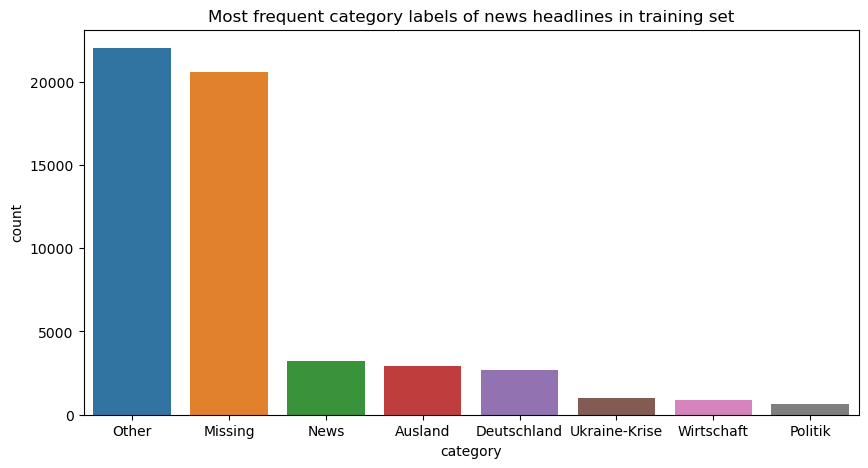

In [130]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=train, x='category', order=train['category'].value_counts().index)
plt.title('Most frequent category labels of news headlines in training set')
plt.show()

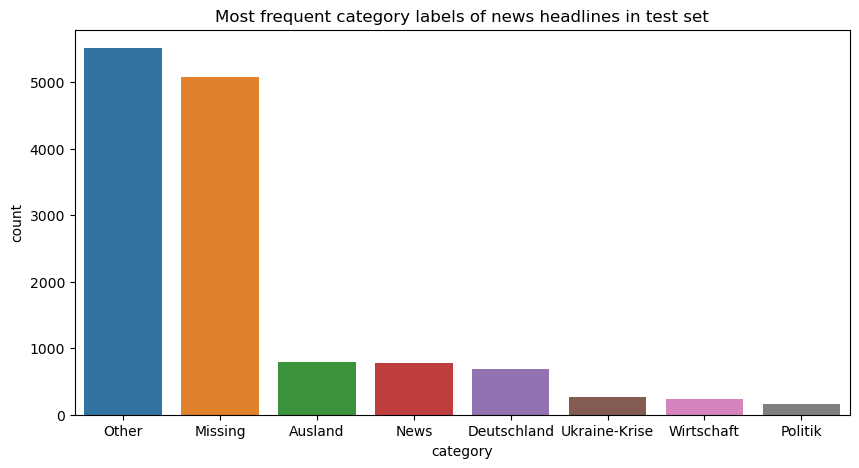

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=test, x='category', order=test['category'].value_counts().index)
plt.title('Most frequent category labels of news headlines in test set')
plt.show()

### Store news

In [132]:
train.to_csv('train_with_open_source.csv', index=False)
test.to_csv('test_with_open_source.csv', index=False)